# Run The Agent on Mountain Car

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import gym

import pandas as pd

In [2]:
from vae_recurrent import VAE, create_decoder, create_encoder
from transition_gru import TransitionGRU
from recurrent_agent import DAIFAgentRecurrent
from prior_model import PriorModelBellman
from habitual_action_network import HabitualAction, compute_discounted_cumulative_reward
from ddpg import *

In [3]:
from util import random_observation_sequence, transform_observations, test_policy, habit_policy
from train_agent import train_single_agent

In [4]:
# from identity_vae import IdentityVAE, identity_encoder, identity_decoder

What does the agent do?
- The agent plans using a policy then executes that policy for 12 simulation timesteps, the first two actions of the policy are executed for 6 steps each

What data does it accumulate?
- It accumulates 12 observation actions pairs

How is it trained?
- VAE is trained to reproduce observations using the latent states
- Transition is trained by taking previous hidden state and previous latent state and trying to predict the next latent state


Online learning For all tasks, we initialize all the agents with random weights and learn online only. Training an agent for 150 epochs takes about 3 minutes on a single CPU core (Intel I7-4870HQ). In contrast, previous approaches using active inference [Ueltzhöffer, 2018, Tschantz et al., 2019, 2020] and policy gradient methods (e.g., [Liu et al., 2017]) use (offline) policy replay and typically need hours of GPU-accelerated compute while achieving similar convergence. To our knowledge, this is the first model-based RL method to learn online using neural network representations. This is afforded by the high sample efficiency of the FEEF, which directs exploration towards states that are uncertain for both the encoder and transition models.


Why this is true?

In [5]:
# Hide GPU from visible devices
tf.config.set_visible_devices([], 'GPU')

## Test with no prior model FEEF

In [20]:
pln_hrzn = 5
latent_dim = 2
obs_dim = 3

# make the VAE
enc = create_encoder(obs_dim, latent_dim, [20])
dec = create_decoder(latent_dim, obs_dim, [20])
vae = VAE(enc, dec, latent_dim,  [0]*latent_dim, [0.3]*latent_dim, train_epochs=2, show_training=True)
vae.compile(optimizer=tf.keras.optimizers.Adam())

# make the TRANSITION
tran = TransitionGRU(latent_dim, 1, 2*pln_hrzn*latent_dim, 2, train_epochs=2, show_training=True)
tran.compile(optimizer=tf.keras.optimizers.Adam())

# make the HABIT ACTION NET
habit_net = HabitualAction(latent_dim, 1, [16, 16], train_epochs=2, show_training=False)
habit_net.compile(optimizer=tf.keras.optimizers.Adam())

# # # make the HABIT ACTION NET
# actor_model = get_actor(2, 1)
# critic_model = get_critic(2, 1)
# target_actor = get_actor(2, 1)
# target_critic = get_critic(2, 1)
#
# # Making the weights equal initially
# target_actor.set_weights(actor_model.get_weights())
# target_critic.set_weights(critic_model.get_weights())
# critic_optimizer = tf.keras.optimizers.Adam(0.0001)
# actor_optimizer = tf.keras.optimizers.Adam(0.00005)
# habit_net = BasicDDPG(actor_model, critic_model, target_actor, target_critic, tau=0.005, critic_optimizer=critic_optimizer, actor_optimizer=actor_optimizer)


# make the PRIOR NET
prior_model = PriorModelBellman(latent_dim, output_dim=1, scaling_factor=1, show_training=False, use_tanh_on_output=False)

# unscaled prior mean and prior stddev
prior_mean = [0, 0, 0]
prior_stddev = [1, 1, 1]

observation_max = np.array([1, 1, 8])
observation_min = np.array([-1, -1, -8])

# observation_noise_stddev = [0, 0]
observation_noise_stddev = [0.05, 0.05, 0.05]

scaled_prior_mean = transform_observations(prior_mean, observation_max, observation_min, [0,0,0])  # no noise on prior

In [21]:
daifa = DAIFAgentRecurrent(prior_model,
                           vae,
                           tran,
                           habit_net,
                           planning_horizon=pln_hrzn,
                           use_kl_extrinsic=True,  # maybe this works
                           use_kl_intrinsic=True,
                           use_FEEF=False,
                           train_habit_net=True,
                           train_prior_model=True,
                           train_tran=True,
                           train_after_exploring=True,
                           train_with_replay=True,
                           use_fast_thinking=True,
                           habit_model_type="PG",
                           uncertainty_tolerance=0.1,
                           min_rewards_needed_to_train_prior=-30)


daifa.train_prior = True
daifa.prior_model.show_training = False

In [22]:
env = gym.make("Pendulum-v1")
env.action_space.sample()

array([1.0795482], dtype=float32)

In [23]:
# train the agent on the env
env = gym.make("Pendulum-v1")
daifa, results_one = train_single_agent(env, daifa, observation_max, observation_min, observation_noise_stddev, num_episodes=60, render_env=False)

Episode 1
[ 0.46496177  0.88533074 -0.2899176 ]
fast thinking
Epoch 1/2
1/1 [==============================] - 1s 525ms/step - kl_loss: 0.3682
Epoch 2/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 0.3558
Epoch 1/2
1/1 [==============================] - 0s 193ms/step - loss: 300.3416 - reconstruction_loss: 292.7230 - kl_loss: 7.6186
Epoch 2/2
1/1 [==============================] - 0s 1ms/step - loss: 370.9782 - reconstruction_loss: 363.4541 - kl_loss: 7.5241
Epoch 1/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 0.4107
Epoch 2/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 0.3980
Epoch 1/2
1/1 [==============================] - 0s 2ms/step - loss: 222.8383 - reconstruction_loss: 214.0977 - kl_loss: 8.7406
Epoch 2/2
1/1 [==============================] - 0s 1ms/step - loss: 280.5497 - reconstruction_loss: 271.7922 - kl_loss: 8.7574
Epoch 1/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 0.4214
Epoch 2/2
1/1 [============

In [12]:
p = habit_policy(daifa)
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 20, daifa.agent_time_ratio)
res

,reward,timesteps,num_actions
0,-240.178894,204,34
1,-236.250809,204,34
2,-177.518585,204,34
3,-294.603455,204,34
4,-225.212326,204,34
5,-243.501526,204,34
6,-241.293915,204,34
7,-245.386963,204,34
8,-272.843750,204,34
9,-231.791687,204,34


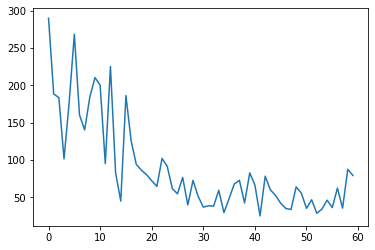

In [13]:
plt.plot(results_one.VFE_post_run)

In [14]:
daifa.train_vae = False
daifa.model_vae.show_training = False

In [15]:
# train the agent on the env
env = gym.make("Pendulum-v1")
daifa, results_two = train_single_agent(env, daifa, observation_max, observation_min, observation_noise_stddev, num_episodes=20, render_env=False)

Episode 1
[0.89164525 0.4527347  0.46346357]
fast thinking
Epoch 1/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 3.3196
Epoch 2/2
1/1 [==============================] - 0s 1ms/step - kl_loss: 3.2106
Epoch 1/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 19.9535
Epoch 2/2
1/1 [==============================] - 0s 1ms/step - kl_loss: 21.1716
Epoch 1/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 61.3554
Epoch 2/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 62.4517
Epoch 1/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 3.0953
Epoch 2/2
1/1 [==============================] - 0s 1ms/step - kl_loss: 2.7895
Epoch 1/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 14.2925
Epoch 2/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 14.0861
Epoch 1/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 43.4001
Epoch 2/2
1/1 [==============================] - 0s 2ms/step - kl

In [16]:
# # make the HABIT ACTION NET
# habit_net = HabitualAction(latent_dim, 1, [16, 16], train_epochs=2, show_training=True)
# habit_net.compile(optimizer=tf.keras.optimizers.Adam())
#
# daifa.habit_action_model = habit_net
#
# actor_model = get_actor(latent_dim, 1)
# critic_model = get_critic(latent_dim, 1)
#
# target_actor = get_actor(latent_dim, 1)
# target_critic = get_critic(latent_dim, 1)
#
# # Making the weights equal initially
# target_actor.set_weights(actor_model.get_weights())
# target_critic.set_weights(critic_model.get_weights())
#
# critic_optimizer = tf.keras.optimizers.Adam(0.0001)
# actor_optimizer = tf.keras.optimizers.Adam(0.00005)
#
# habit_net = BasicDDPG(actor_model, critic_model, target_actor, target_critic, tau=0.005, critic_optimizer=critic_optimizer, actor_optimizer=actor_optimizer)

In [17]:
p = habit_policy(daifa)
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 20, daifa.agent_time_ratio)
res

,reward,timesteps,num_actions
0,-215.116028,204,34
1,-278.625488,204,34
2,-277.194183,204,34
3,-147.607010,204,34
4,-245.454132,204,34
5,-238.050583,204,34
6,-198.725281,204,34
7,-214.721695,204,34
8,-295.793976,204,34
9,-231.240402,204,34


In [18]:
daifa.habit_action_model.show_training = False
daifa.train_habit_net = True
daifa.train_after_exploring = True
daifa.use_kl_intrinsic = True
daifa.use_kl_extrinsic = False
daifa.use_fast_thinking = True
daifa.uncertainty_tolerance = 0.1

# daifa.tran.show_training = False
# daifa.prior_model.show_training = False

# train the agent on the env
env = gym.make("Pendulum-v1")
daifa, results_three = train_single_agent(env, daifa, observation_max, observation_min, observation_noise_stddev, num_episodes=20, render_env=False)

Episode 1
[ 0.01197588 -0.9999283   0.57208574]
fast thinking
Epoch 1/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 6.5205
Epoch 2/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 6.2722
Epoch 1/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 2.8282
Epoch 2/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 2.8101
Epoch 1/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 0.7340
Epoch 2/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 0.7377
Epoch 1/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 1.9838
Epoch 2/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 1.9921
Epoch 1/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 6.5062
Epoch 2/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 6.4153
Epoch 1/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 2.5552
Epoch 2/2
1/1 [==============================] - 0s 2ms/step - kl_los

In [19]:
p = habit_policy(daifa)
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 20, daifa.agent_time_ratio)
res

,reward,timesteps,num_actions
0,-292.885406,204,34
1,-178.971710,204,34
2,-216.117401,204,34
3,-225.894226,204,34
4,-239.553558,204,34
5,-233.857758,204,34
6,-273.116150,204,34
7,-196.400711,204,34
8,-274.928802,204,34
9,-239.118088,204,34


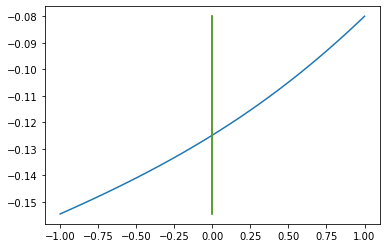

In [38]:
obs_pos = np.vstack([np.linspace(-1, 1, 100), np.zeros(100), np.zeros(100)]).T

latent_mean, _ , _ = daifa.model_vae.encoder(obs_pos)

utils = daifa.prior_model(latent_mean)
# print(utils)

plt.plot(obs_pos, utils)

In [ ]:
vel_pos = np.vstack([np.zeros(100), np.linspace(-1, 1, 100)]).T

latent_mean, _ , _ = daifa.model_vae.encoder(vel_pos)

utils = daifa.prior_model(latent_mean)
# print(utils)

plt.plot(vel_pos, utils)

In [ ]:
obs_pos = np.vstack([np.linspace(-1, 1, 100), np.zeros(100)]).T

latent_mean, _ , _ = daifa.model_vae.encoder(obs_pos)

# utils = daifa.habit_action_model.actor_model(latent_mean)
utils = daifa.select_fast_thinking_policy(latent_mean)
# print(utils)

plt.plot(obs_pos, utils)

In [ ]:
vel_pos = np.vstack([np.zeros(100), np.linspace(-1, 1, 100)]).T

latent_mean, _ , _ = daifa.model_vae.encoder(vel_pos)

# utils = daifa.habit_action_model.actor_model(latent_mean)
utils = daifa.select_fast_thinking_policy(latent_mean)
# print(utils)

plt.plot(vel_pos, utils)

In [43]:
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 5, daifa.agent_time_ratio, show_env=True)
res

[[-0.99992335]]
[[-0.88178855]]
[[0.99789256]]
[[-0.9998848]]
[[-1.]]
[[-0.9999769]]
[[0.99991107]]
[[-0.16730253]]
[[-0.9999739]]
[[-0.8034171]]
[[0.9970662]]
[[-0.9999894]]
[[-1.]]
[[-0.99990356]]
[[0.999879]]
[[-0.97488046]]
[[-0.9999994]]
[[-0.9999995]]
[[-0.9999298]]
[[0.99215883]]
[[-0.9951003]]
[[-1.]]
[[-1.]]
[[0.9989349]]
[[0.9983758]]
[[-0.966355]]
[[0.9603897]]
[[0.9575787]]
[[-1.]]
[[-1.]]
[[-1.]]
[[0.999734]]
[[0.9678278]]
[[-0.999788]]
[[0.99940175]]
[[0.99864036]]
[[0.9983579]]
[[0.9979407]]
[[0.9991464]]
[[0.99915755]]
[[0.99778235]]
[[0.9984719]]
[[0.99706304]]
[[0.998763]]
[[0.9988698]]
[[0.9993559]]
[[0.9990138]]
[[0.99794537]]
[[0.99839854]]
[[0.99911153]]
[[0.9989697]]
[[0.9992252]]
[[0.9982412]]
[[0.9965633]]
[[0.99803454]]
[[0.9994383]]
[[0.99928397]]
[[0.99822474]]
[[0.99837875]]
[[0.998344]]
[[0.9986446]]
[[0.99930716]]
[[0.9991316]]
[[0.9982009]]
[[0.9972399]]
[[0.9988507]]
[[0.9991977]]
[[0.9992266]]
[[0.7610545]]
[[0.99936944]]
[[0.9997359]]
[[0.9990438]]
[[

,reward,timesteps,num_actions
0,-163.081482,204,34
1,-295.807770,204,34
2,-253.660629,204,34
3,-202.541702,204,34
4,-180.507751,204,34


In [22]:
# train the agent on the env
daifa, results_four = train_single_agent(env, daifa, observation_max, observation_min, observation_noise_stddev, num_episodes=50, render_env=False, flip_dynamics=False)

Episode 1
[-0.4574806  0.       ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
training on full data
60 167
No Success
Episode 2
[-0.47844926  0.        ]
fast thinking
fast thinking
fast thi

In [ ]:
p = habit_policy(daifa)
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 20, daifa.agent_time_ratio)
res

In [180]:
# train the agent on the env
env = gym.make('MountainCarContinuous-v0')
daifa, results_four = train_single_agent(env, daifa, observation_max, observation_min, observation_noise_stddev, num_episodes=50, render_env=False, flip_dynamics=True)

Episode 1
[-0.43750945  0.        ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
training on 

In [163]:
p = habit_policy(daifa)
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 20, daifa.agent_time_ratio)
res

,reward,timesteps,num_actions
0,-6.068081,1002,167
1,-6.230983,1002,167
2,-6.431071,1002,167
3,-6.138415,1002,167
4,-6.204773,1002,167
5,-6.439107,1002,167
6,-6.316643,1002,167
7,-6.352924,1002,167
8,-6.375400,1002,167
9,-6.346141,1002,167


In [164]:
p = habit_policy(daifa)
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 4, daifa.agent_time_ratio, show_env=False)
res

,reward,timesteps,num_actions
0,-6.402275,1002,167
1,-6.180096,1002,167
2,-6.352802,1002,167
3,-6.167919,1002,167


In [ ]:
full_results = pd.concat([results_one, results_two, results_three, results_four])
full_results.reset_index(drop=True)
full_results

In [ ]:
T = np.arange(len(full_results))
plt.plot(T, full_results.percent_use_fast_thinking)

In [ ]:
plt.plot(T, full_results.success)

In [ ]:
plt.plot(T, full_results.total_reward)

In [ ]:
plt.plot(T, full_results.sim_steps)